In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import pandas as pd 
import seaborn as sns
from glob import glob 
import numpy as np 
import optax as ox

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-05-19 09:50:35.851042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Data Read

### Obs

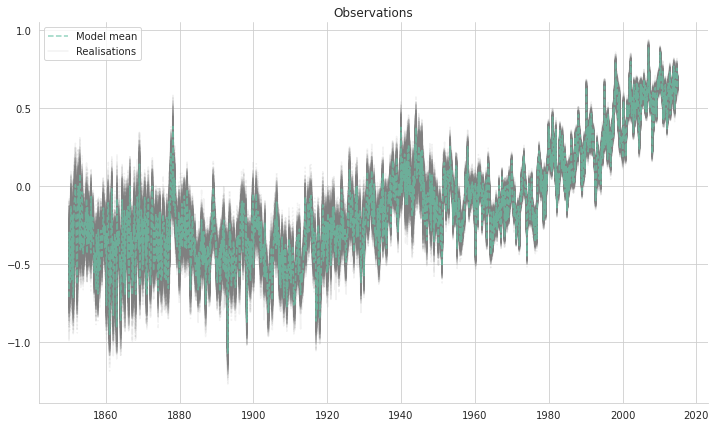

In [2]:
obs_df = pd.read_csv("data/obs/GMST_OBS.csv", index_col="time")#.iloc[:, :10]
observations = es.ProcessModel(obs_df, model_name='Observations')
observations.plot()
sns.despine()

### Anomaly model data

In [3]:
hist_model_files = dict()
for model_file in sorted(glob('data/gmst/historical/*csv')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    hist_model_files[model_name] = model_file

ssp_model_files = dict()
for model_file in sorted(glob('data/gmst/ssp370/*csv')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    ssp_model_files[model_name] = model_file

model_overlap = np.intersect1d(list(hist_model_files.keys()), list(ssp_model_files.keys())).tolist()
hist_model_files = {k:hist_model_files[k] for k in hist_model_files if k in model_overlap}
ssp_model_files = {k:ssp_model_files[k] for k in ssp_model_files if k in model_overlap}

hist_anom_model_set = []
hist_models = []
climatology_dict = dict()

for mn, mf in hist_model_files.items():
    # Read in model data into a ProcessModel datatype
    df = pd.read_csv(mf, index_col='time').drop('Unnamed: 0', axis=1)
    model_data = es.ProcessModel(df, mn)
    hist_models.append(model_data)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    hist_anom_model_set.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

ssp_anom_models = []
ssp_models = []

for mn, mf in ssp_model_files.items():
    # Read in model data into a ProcessModel datatype
    df = pd.read_csv(mf, index_col='time').drop('Unnamed: 0', axis=1)
    model_data = es.ProcessModel(df, mn)
    ssp_models.append(model_data)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(climatology=climatology_dict[mn], resample_freq='Y')
    ssp_anom_models.append(anomaly_model)

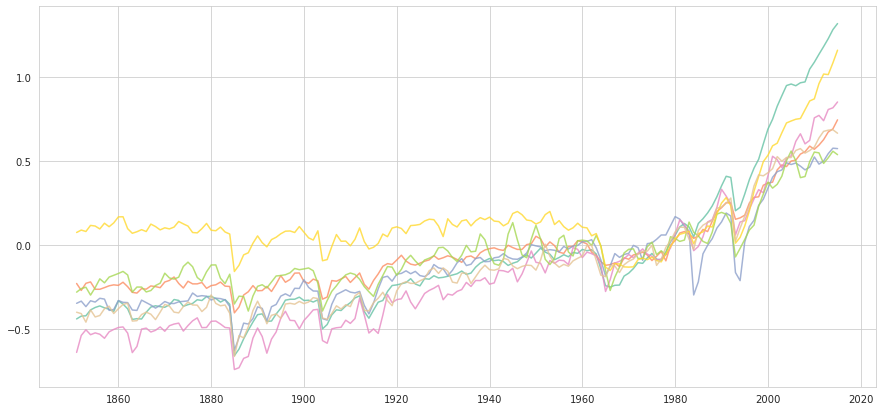

In [4]:
hist_anom_models = es.ModelCollection(hist_anom_model_set)
hist_anom_models.plot_all()

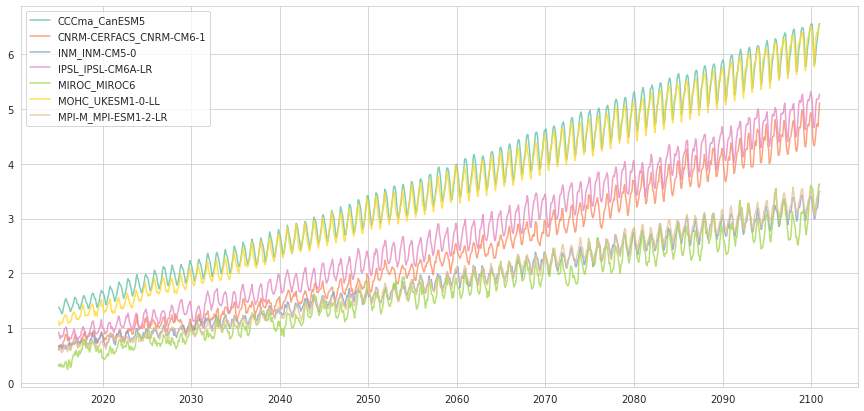

In [5]:
ssp_anom_models = es.ModelCollection(ssp_anom_models)
ssp_models = es.ModelCollection(ssp_models)
ax = ssp_anom_models.plot_all()
ax.legend(loc='best')

In [10]:
hist_anom_models.fit(model=es.GPDTW(), compile_objective=True)

100%|██████████| 500/500 [00:24<00:00, 20.24it/s, loss=-123.59]
/home/pindert2/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "
100%|██████████| 500/500 [00:24<00:00, 20.65it/s, loss=-182.43]


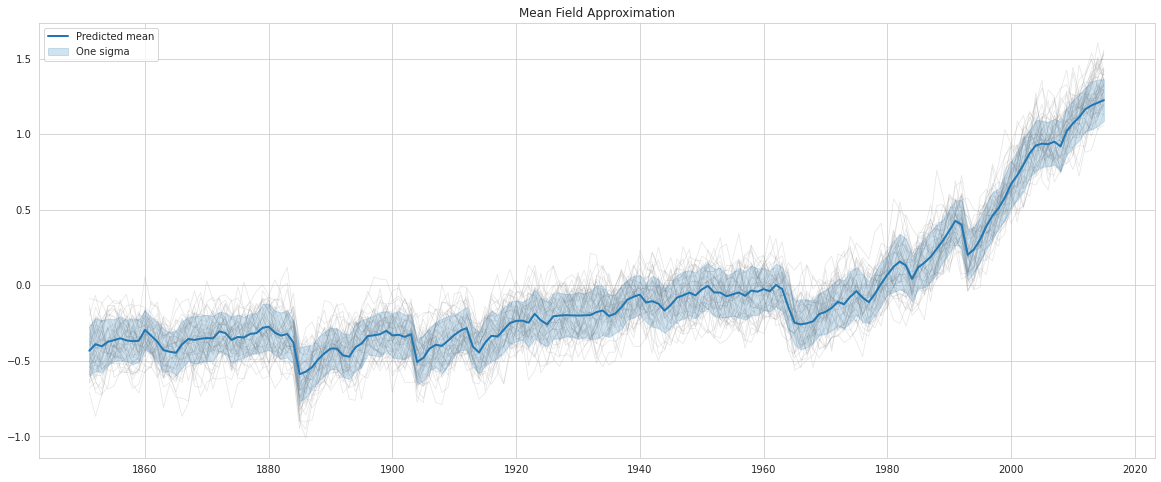

In [11]:
mu = hist_anom_models[0].distribution.mean()
stddev = hist_anom_models[0].distribution.stddev()
realisations = hist_anom_models[0].model_data.values

fig,ax = plt.subplots(figsize=(20,8))
ax.plot(hist_anom_models[0].time, mu, color='tab:blue', label='Predicted mean', linewidth=2, zorder=2)
ax.fill_between(hist_anom_models[0].time, mu - stddev, mu + stddev, color='tab:blue', alpha=0.2, label='One sigma', zorder=2)
ax.plot(hist_anom_models[0].time, realisations, color='tab:gray', alpha=0.2, zorder=1, linewidth=0.7)
ax.legend(loc='best')
ax.set_title('Mean Field Approximation')
plt.show()

In [12]:
weight_function = es.LogLikelihoodWeight()
weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:01<00:00, 166.60it/s]


In [13]:
ensemble = es.Barycentre()
pdfs = ensemble(hist_anom_models, weights)

100%|██████████| 165/165 [00:01<00:00, 91.10it/s]


## Hindcast Ensemble

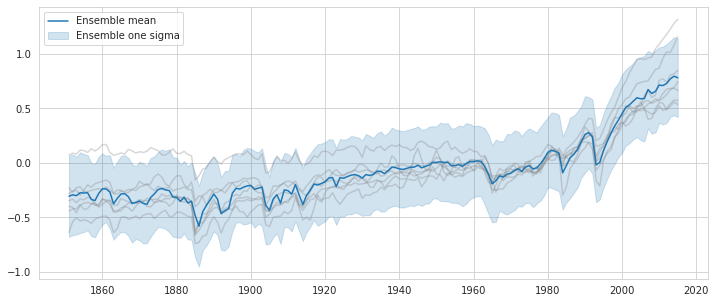

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
hist_anom_models.plot_all(one_color='tab:gray', ax=ax)
ensemble.plot(ax, x=hist_anom_models.time)
ax.legend(loc='best')

## Forecast Ensemble

In [16]:
ssp_anom_models.fit(model=es.GPDTW(), compile_objective=True, n_optim_nits=1000)

  4%|▍         | 41/1000 [00:30<11:59,  1.33it/s, loss=1042.36]


KeyboardInterrupt: 

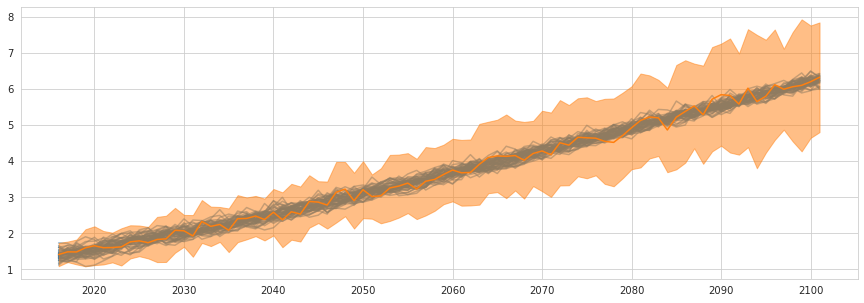

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))

mu = ssp_anom_models.models[0].distribution.mean()
sigma = ssp_anom_models.models[0].distribution.stddev()

ax.plot(ssp_anom_models.models[0].time, ssp_anom_models.models[0].model_data.values, color='tab:blue', alpha=0.5, zorder=1)
ax.plot(ssp_anom_models.models[0].time, mu, color='tab:orange', zorder=2)
ax.fill_between(ssp_anom_models.models[0].time, mu - sigma, mu + sigma, color='tab:orange', alpha=0.5, zorder=2)
plt.show()

In [37]:
ensemble = es.Barycentre()
pdfs = ensemble(ssp_anom_models, weights)

100%|██████████| 86/86 [00:00<00:00, 101.86it/s]


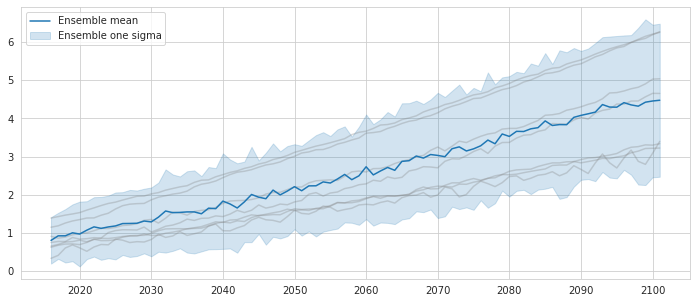

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
ssp_anom_models.plot_all(one_color='tab:gray', ax=ax)
ensemble.plot(ax, x=ssp_anom_models.time)
ax.legend(loc='best')

In [55]:
ssp_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True, n_optim_nits=500)

/home/pindert2/bayesian_ensembling/ensembles/models.py:93: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
Objective: -5735.40: 100%|██████████| 500/500 [00:01<00:00, 254.51it/s] 


100%|██████████| 1032/1032 [00:09<00:00, 105.09it/s]


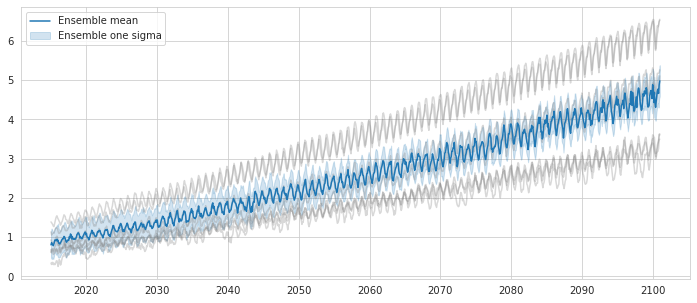

In [56]:
ensemble = es.Barycentre()
pdfs = ensemble(ssp_anom_models, weights)

fig, ax = plt.subplots(figsize=(12, 5))
ssp_anom_models.plot_all(one_color='tab:gray', ax=ax)
ensemble.plot(ax, x=ssp_anom_models.time)
ax.legend(loc='best')

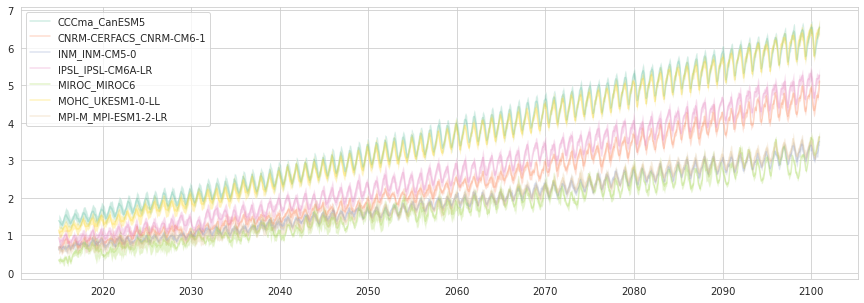

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
ssp_anom_models.plot_posteriors(ax=ax)
ax.legend(loc='best')

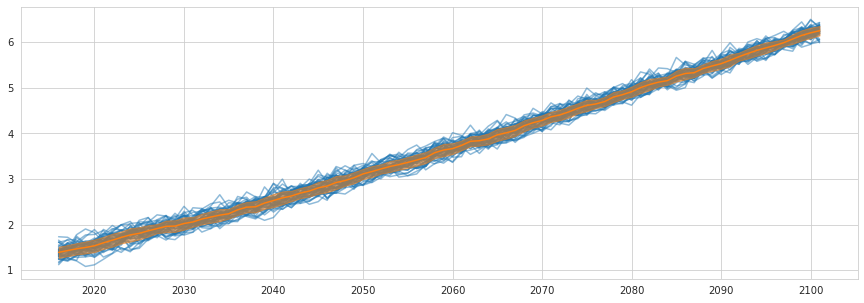

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

mu = ssp_anom_models.models[0].distribution.mean()
sigma = ssp_anom_models.models[0].distribution.stddev()

ax.plot(ssp_anom_models.models[0].time, ssp_anom_models.models[0].model_data.values, color='tab:blue', alpha=0.5, zorder=1)
ax.plot(ssp_anom_models.models[0].time, mu, color='tab:orange', zorder=2)
ax.fill_between(ssp_anom_models.models[0].time, mu - sigma, mu + sigma, color='tab:orange', alpha=0.5, zorder=2)
plt.show()

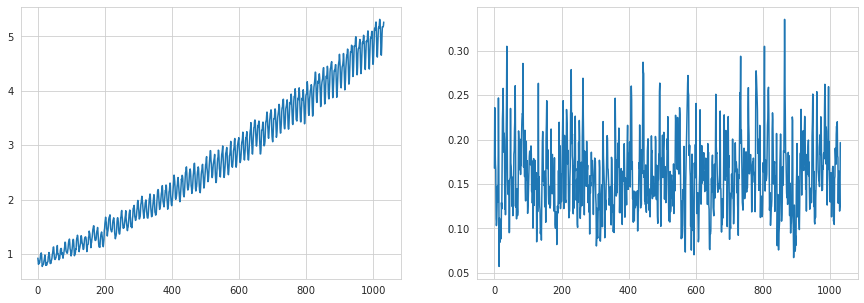

In [74]:
temp_vals = ssp_anom_models[3].model_data.values
temp_mu = np.mean(temp_vals, axis=1)
temp_sigma = np.std(temp_vals, axis=1)

f, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.plot(temp_mu)
ax1.plot(temp_sigma)